## Import libraries

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import ETFs as etfs

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers


Total number of ETFs: 33


## Read CSV

In [3]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
print(data.columns.tolist())
data.set_index('Date', inplace=True)
display(data)


['Date', 'AIEQ', 'ASHR.L', 'BCHN.L', 'CORN', 'DBO', 'EDEN', 'EMXC', 'EWA', 'EWC', 'EWG', 'EWH', 'EWJ', 'EWQ', 'EWS', 'EWU', 'EWW', 'GLD', 'IDUP.L', 'IEMG', 'INDA', 'KSA', 'PSCC', 'SEMI.AS', 'SLV', 'SPY', 'TLT', 'USO', 'VDE', 'VDNR.L', 'VGK', 'VNQ', 'VPL', 'XMAF.L']


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902443,6.246624,40.000000,42.619999,26.042212,22.380077,42.757008,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,42.300957,27.664722,34.591938,33.707809,6.78375
2012-01-04,21.902443,6.246624,40.000000,42.509998,26.165096,22.380077,42.757008,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,42.300957,27.328695,34.000530,33.888020,6.69750
2012-01-05,21.902443,6.246624,40.000000,41.509998,25.814005,22.380077,42.757008,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,42.300957,26.831099,34.319885,33.472149,6.68250
2012-01-06,21.902443,6.246624,40.000000,41.349998,25.919331,22.380077,42.757008,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,42.300957,26.462753,34.207520,33.070118,6.72625
2012-01-09,21.902443,6.246624,40.000000,42.189999,25.831558,22.380077,42.757008,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,42.300957,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [4]:
first_prices = data.iloc[:1]
first_prices.values

array([[ 21.90244293,   6.24662399,  40.        ,  42.61999893,
         26.04221153,  22.38007736,  42.7570076 ,  12.30733013,
         20.62557411,  14.72088146,  10.45192623,  30.00427818,
         14.19258881,  13.14745522,  19.75927925,  41.37704086,
        155.91999817,  13.62710571,  35.37962341,  23.19848824,
         20.75997353,   8.67868042,   5.19500017,  28.82999992,
        100.45068359,  83.88857269, 317.51998901,  69.90565491,
         42.30095673,  27.66472244,  34.59193802,  33.70780945,
          6.78375006]])

In [5]:
normalized_data = data.copy()
normalized_data = data / first_prices.values
normalized_data

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2012-01-04,1.000000,1.000000,1.000000,0.997419,1.004719,1.000000,1.000000,1.011775,0.998175,0.990533,...,0.984738,1.001569,0.988110,1.002016,1.002994,1.000000,0.987854,0.982903,1.005346,0.987286
2012-01-05,1.000000,1.000000,1.000000,0.973956,0.991237,1.000000,1.000000,0.998641,0.991971,0.979073,...,0.988900,1.004235,0.986352,0.986898,0.998744,1.000000,0.969867,0.992135,0.993009,0.985075
2012-01-06,1.000000,1.000000,1.000000,0.970202,0.995281,1.000000,1.000000,0.985507,0.981752,0.961136,...,0.968089,1.001647,0.994139,0.988158,0.992660,1.000000,0.956552,0.988887,0.981082,0.991524
2012-01-09,1.000000,1.000000,1.000000,0.989911,0.991911,1.000000,1.000000,0.988677,0.984671,0.965122,...,0.975720,1.004078,0.992381,0.984631,0.996426,1.000000,0.963793,0.985468,0.981904,0.987102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1.747568,1.665700,2.513750,0.444158,0.542965,4.822593,1.321187,1.925682,2.012550,2.583405,...,1.039195,5.715043,1.058428,0.235828,1.845788,3.316001,2.592833,2.622808,2.215807,1.221669
2025-03-25,1.752316,1.671303,2.518000,0.440404,0.538741,4.795783,1.323292,1.934619,2.022247,2.607181,...,1.060701,5.728782,1.058311,0.235639,1.851925,3.320965,2.608376,2.593379,2.227674,1.201216
2025-03-26,1.728300,1.664899,2.454250,0.435476,0.541813,4.729206,1.311598,1.926494,2.006247,2.551478,...,1.058966,5.660390,1.051354,0.237528,1.863226,3.300044,2.571506,2.603497,2.207500,1.200663


In [6]:
print(f"normalized_size = {data.shape}")
def create_X_y(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X_window = df.iloc[i : i + window_size].values
        y_target = df.iloc[i + window_size].values
        X.append(X_window)
        y.append(y_target)
    X = np.array(X)
    y = np.array(y)
    return X, y
window_size = 30
X, y = create_X_y(normalized_data, window_size)
print(X.shape)
print(y.shape)


normalized_size = (3408, 33)
(3378, 30, 33)
(3378, 33)


## Train the model

In [7]:
dataset_size = len(X)
print(dataset_size)


train_size = int(dataset_size * 0.8)
test_size =int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size


X_train, X_val, X_test = X[:train_size], X[train_size: train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test= y[:train_size], y[train_size: train_size + val_size], y[train_size + val_size:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


3378


((2702, 30, 33),
 (2702, 33),
 (339, 30, 33),
 (339, 33),
 (337, 30, 33),
 (337, 33))

In [8]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  
    LSTM(64, return_sequences=False),  
    Dense(y_train.shape[1])  
])

cp = ModelCheckpoint(filepath='model/best_first.keras', save_best_only=True, monitor='val_loss', mode='min')

model.compile(loss=MeanSquaredError(), 
              optimizer=Adam(learning_rate=0.001), 
              metrics=[MeanSquaredError()])

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp]
)
# model.summary()



c:\Users\Shelly\Desktop\BachelorProject\BAvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.9320 - mean_squared_error: 0.9317 - val_loss: 0.1787 - val_mean_squared_error: 0.1862
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0472 - mean_squared_error: 0.0472 - val_loss: 0.0848 - val_mean_squared_error: 0.0881
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0808 - val_mean_squared_error: 0.0842
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0796 - val_mean_squared_error: 0.0825
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0775 - val_mean_squared_error: 0.0800
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0725 - val_mean_squared_error: 0.0748
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.069

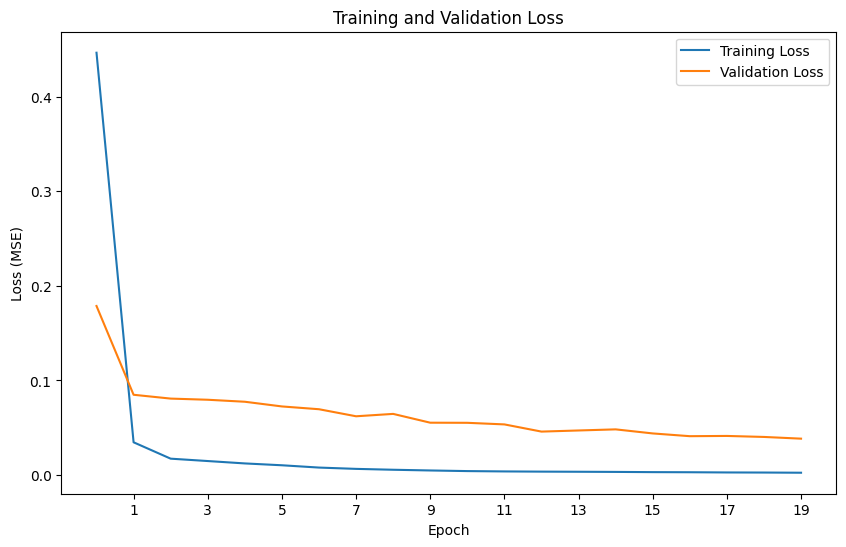

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_squared_error'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
xticks = np.arange(1, 21, 2)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

## Predictions

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,34.984264,11.737871,88.381329,25.643874,15.952128,93.753295,54.786014,21.458009,35.553464,26.744150,...,22.909647,386.072110,109.781432,76.741159,93.347927,96.713391,53.279274,85.444059,66.637980,7.157878
2023-12-08,35.092468,11.769791,88.832979,25.541102,15.914248,93.973932,54.904668,21.477155,35.553980,26.808125,...,22.897114,386.654844,110.062340,76.551244,93.094308,96.850894,53.383507,85.508512,66.770737,7.159772
2023-12-11,35.205831,11.803128,89.331369,25.426225,15.873640,94.202753,55.028073,21.498273,35.551873,26.874435,...,22.895485,387.267875,110.344899,76.435235,92.833273,96.985907,53.499939,85.570029,66.922250,7.163497
2023-12-12,35.307299,11.831805,89.788618,25.297178,15.834440,94.406304,55.139117,21.510524,35.553338,26.927902,...,22.872409,387.900496,110.592206,76.338293,92.578454,97.148876,53.617677,85.626994,67.047761,7.160544
2023-12-13,35.386190,11.860634,90.191183,25.163454,15.783018,94.588138,55.237744,21.516255,35.549355,26.972746,...,22.834439,388.444480,110.840454,76.107584,92.299835,97.297453,53.725416,85.673418,67.161398,7.157053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.644046,13.220970,101.064863,24.793226,15.188202,100.643416,55.091398,21.975455,37.581855,28.041687,...,23.291393,428.270409,121.912253,80.312522,88.652688,105.293973,58.387323,95.471109,69.460451,7.707062
2025-03-25,38.622242,13.214557,101.002293,24.821004,15.208613,100.578788,55.049597,21.978672,37.585653,28.024163,...,23.306410,428.098980,121.800949,80.620272,88.712055,105.251241,58.367667,95.425823,69.448083,7.706099
2025-03-26,38.597623,13.206764,100.925722,24.856833,15.238251,100.504812,55.013954,21.979407,37.584677,28.002331,...,23.321886,427.935071,121.689486,80.934391,88.801589,105.208601,58.347676,95.390929,69.431118,7.703325


<Axes: xlabel='Date'>

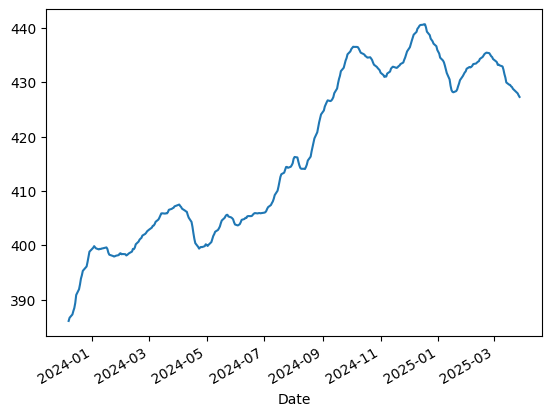

In [10]:
model = load_model('model/best_first.keras')
Y_pred = model.predict(X_test)

index_series = data.index[-len(y_test):]
Y_pred_denormalized = Y_pred * first_prices.values

Y_pred_df = pd.DataFrame(Y_pred_denormalized, index = index_series, columns = data.columns)

display(Y_pred_df)

Y_pred_df["SPY"].plot()



In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming y_test and y_pred are your actual and predicted values
mse = mean_squared_error(y_test, Y_pred)
mae = mean_absolute_error(y_test, Y_pred)
r2 = r2_score(y_test, Y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")


Mean Squared Error: 0.1619
Mean Absolute Error: 0.2885
R-squared: -9.6731


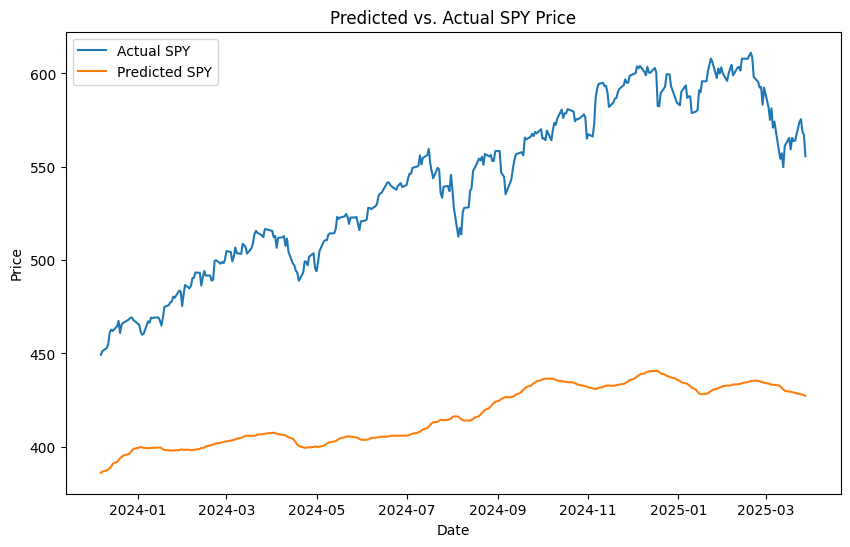

In [12]:
y_actual = pd.DataFrame(y_test * first_prices.values, index=index_series, columns=data.columns)

plt.figure(figsize=(10,6))
plt.plot(y_actual["SPY"], label='Actual SPY')
plt.plot(Y_pred_df["SPY"], label='Predicted SPY')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted vs. Actual SPY Price')
plt.legend()
plt.show()


In [13]:
print("Mean of actual normalized prices:", np.mean(y_test))
print("Mean of predicted normalized prices:", np.mean(Y_pred))


Mean of actual normalized prices: 1.991787477213212
Mean of predicted normalized prices: 1.8610661


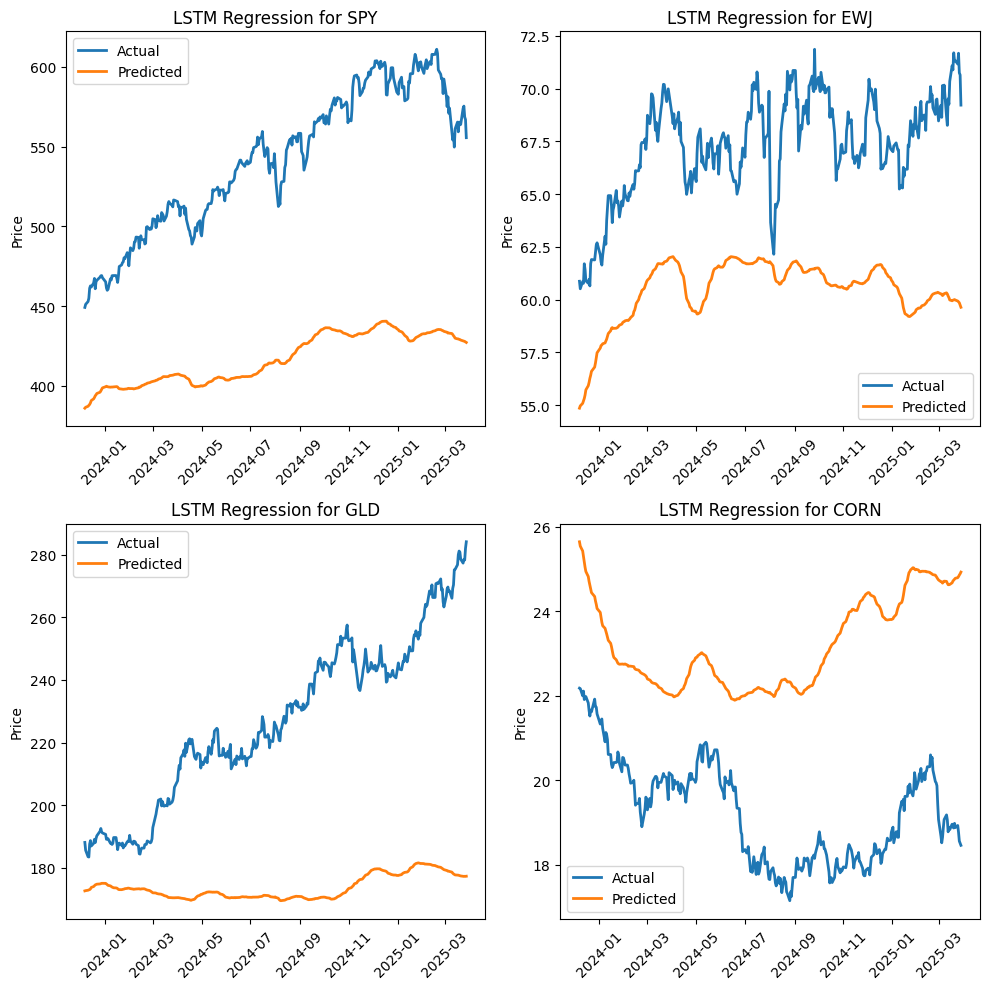

In [14]:
ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN']  

num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten() 


for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(Y_pred_df[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'LSTM Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [15]:
label = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
label_test = label.iloc[-len(y_test):]
label_test.set_index('Date', inplace=True)
display(label_test)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,1,1,0,1,1,1,1,1,0,1,...,0,1,0,1,0,0,1,1,1,0
2023-12-08,1,0,1,0,1,0,0,1,1,1,...,0,1,0,1,1,1,1,0,0,0
2023-12-11,1,1,0,0,1,0,1,0,1,1,...,0,1,0,1,1,1,1,1,1,1
2023-12-12,0,0,1,1,0,0,0,1,0,1,...,0,1,1,0,0,1,1,0,1,0
2023-12-13,1,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,1,1,0,1,1,0
2025-03-25,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,0
2025-03-26,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [16]:
Y_pred_df

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,34.984264,11.737871,88.381329,25.643874,15.952128,93.753295,54.786014,21.458009,35.553464,26.744150,...,22.909647,386.072110,109.781432,76.741159,93.347927,96.713391,53.279274,85.444059,66.637980,7.157878
2023-12-08,35.092468,11.769791,88.832979,25.541102,15.914248,93.973932,54.904668,21.477155,35.553980,26.808125,...,22.897114,386.654844,110.062340,76.551244,93.094308,96.850894,53.383507,85.508512,66.770737,7.159772
2023-12-11,35.205831,11.803128,89.331369,25.426225,15.873640,94.202753,55.028073,21.498273,35.551873,26.874435,...,22.895485,387.267875,110.344899,76.435235,92.833273,96.985907,53.499939,85.570029,66.922250,7.163497
2023-12-12,35.307299,11.831805,89.788618,25.297178,15.834440,94.406304,55.139117,21.510524,35.553338,26.927902,...,22.872409,387.900496,110.592206,76.338293,92.578454,97.148876,53.617677,85.626994,67.047761,7.160544
2023-12-13,35.386190,11.860634,90.191183,25.163454,15.783018,94.588138,55.237744,21.516255,35.549355,26.972746,...,22.834439,388.444480,110.840454,76.107584,92.299835,97.297453,53.725416,85.673418,67.161398,7.157053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.644046,13.220970,101.064863,24.793226,15.188202,100.643416,55.091398,21.975455,37.581855,28.041687,...,23.291393,428.270409,121.912253,80.312522,88.652688,105.293973,58.387323,95.471109,69.460451,7.707062
2025-03-25,38.622242,13.214557,101.002293,24.821004,15.208613,100.578788,55.049597,21.978672,37.585653,28.024163,...,23.306410,428.098980,121.800949,80.620272,88.712055,105.251241,58.367667,95.425823,69.448083,7.706099
2025-03-26,38.597623,13.206764,100.925722,24.856833,15.238251,100.504812,55.013954,21.979407,37.584677,28.002331,...,23.321886,427.935071,121.689486,80.934391,88.801589,105.208601,58.347676,95.390929,69.431118,7.703325


In [17]:
y_test_shift = data[train_size + val_size + window_size - 1: -1]
y_test_shift_index = data.index[train_size + val_size + window_size-1: -1]

y_test_shift_df = pd.DataFrame(y_test_shift, index=y_test_shift_index, columns=data.columns)
y_test_shift_array = y_test_shift_df.values


predicted_directions = (Y_pred_df > y_test_shift_array).astype(int)
predicted_directions_df = pd.DataFrame(predicted_directions, index=index_series, columns=data.columns)
display(predicted_directions_df)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,1,1,1,1,1,0,1,1,1,0,...,1,0,1,1,0,0,0,1,1,1
2023-12-08,1,1,1,1,1,0,1,0,1,0,...,1,0,1,1,0,0,0,1,1,1
2023-12-11,1,1,1,1,1,0,1,0,1,0,...,1,0,1,1,0,0,0,1,1,1
2023-12-12,1,1,1,1,1,0,1,0,1,0,...,1,0,1,1,0,0,0,1,1,1
2023-12-13,1,1,1,1,1,0,1,0,1,0,...,1,0,1,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
2025-03-25,1,1,1,1,1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
2025-03-26,1,1,1,1,1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0


In [18]:
actual_flat = label_test.to_numpy().flatten()
predicted_flat = predicted_directions_df.to_numpy().flatten()

matches = np.sum(actual_flat == predicted_flat)
percentage = (matches / len(actual_flat)) * 100
print(f"Match Percentage: {percentage:.2f}%")

accuracy = accuracy_score(actual_flat, predicted_flat)
print(f'Accuracy of the model: {accuracy:.4f}')

Match Percentage: 49.44%
Accuracy of the model: 0.4944


### Accuracy

In [19]:
yesterday_prices = data.iloc[-2]  
today_prices_actual = data.iloc[-1] 


Y_pred_mean = Y_pred.mean(axis=0)
Y_pred_real = Y_pred_mean * first_prices.values
today_prices_predicted = pd.Series(Y_pred_real.flatten(), index=data.columns)


comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_pred': today_prices_predicted,
})

tickers_names = data.columns

correct_list = []
for ticker in tickers_names:
    yesterday = yesterday_prices[ticker]
    actual_today = today_prices_actual[ticker]
    predicted = today_prices_predicted[ticker]

    sign_actual = np.sign(actual_today - yesterday)
    sign_pred = np.sign(predicted - yesterday)

    if sign_actual == sign_pred:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list

count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
# display(comparison_df)
save_df = pd.DataFrame()
save_df['Yesterday actual'] = comparison_df['Yesterday_actual'].apply(lambda x: round(x, 2))
save_df['Today actual'] = comparison_df['Today_actual'].apply(lambda x: round(x, 2))
save_df['Today pred target'] = comparison_df['Today_pred'].apply(lambda x: round(x, 2))
save_df['Correct'] = comparison_df['Correct']
display(save_df)
save_df.to_csv('rnn_regression.csv', index=True)


Count of correct predictions: 21
accuracy: 0.6363636363636364


,Yesterday actual,Today actual,Today pred target,Correct
AIEQ,37.66,36.85,38.73,0
ASHR.L,10.46,10.34,13.32,0
BCHN.L,97.08,92.71,104.97,0
CORN,18.51,18.46,23.20,0
DBO,14.13,13.97,14.24,0
EDEN,105.33,105.17,101.64,1
EMXC,56.11,55.18,56.62,0
EWA,23.75,23.47,22.04,1
EWC,41.25,40.57,36.68,1
EWG,37.59,37.39,29.00,1


### Accuracy

In [20]:
correct = 0
total = len(tickers_names)
print(f"Total Tickers: {total}")
print(f"used_data columns: {tickers_names}")

for ticker in tickers_names:
    yesterday = yesterday_prices[ticker]
    actual_today = today_prices_actual[ticker]
    predicted = today_prices_predicted[ticker]

    sign_actual = np.sign(actual_today - yesterday)
    sign_pred = np.sign(predicted - yesterday)

    if sign_actual == sign_pred:
        correct += 1

accuracy = correct / total
print(f"Accuracy: {accuracy:%}")


Total Tickers: 33
used_data columns: Index(['AIEQ', 'ASHR.L', 'BCHN.L', 'CORN', 'DBO', 'EDEN', 'EMXC', 'EWA', 'EWC',
       'EWG', 'EWH', 'EWJ', 'EWQ', 'EWS', 'EWU', 'EWW', 'GLD', 'IDUP.L',
       'IEMG', 'INDA', 'KSA', 'PSCC', 'SEMI.AS', 'SLV', 'SPY', 'TLT', 'USO',
       'VDE', 'VDNR.L', 'VGK', 'VNQ', 'VPL', 'XMAF.L'],
      dtype='object')
Accuracy: 63.636364%
